**Note:** This notebook can run using TensorFlow 2.5.0

In [1]:
!pip install tensorflow==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.4/462.4 KB 46.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 117.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


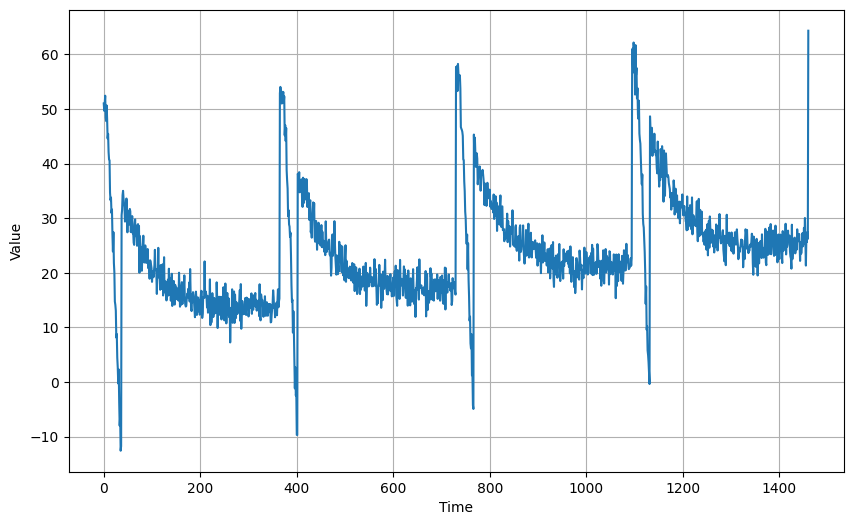

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Просто произвольный шаблон, вы можете изменить его, если хотите"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Повторяет один и тот же шаблон в каждом периоде"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

#Создать последовательность
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
#Добавляем шум
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# График должен иметь пять характерных "пиков"

Теперь, когда у нас есть временной ряд, давайте разделим его на обучающую и тестовую части, чтобы начать прогнозирование.

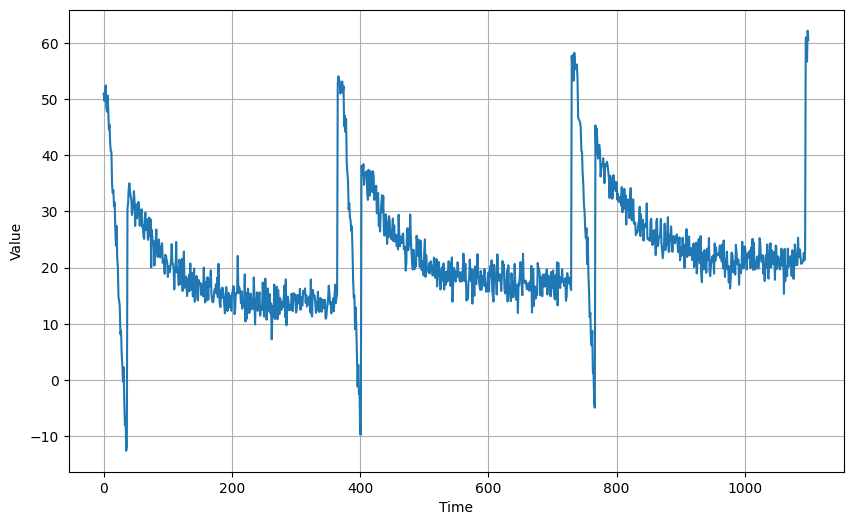

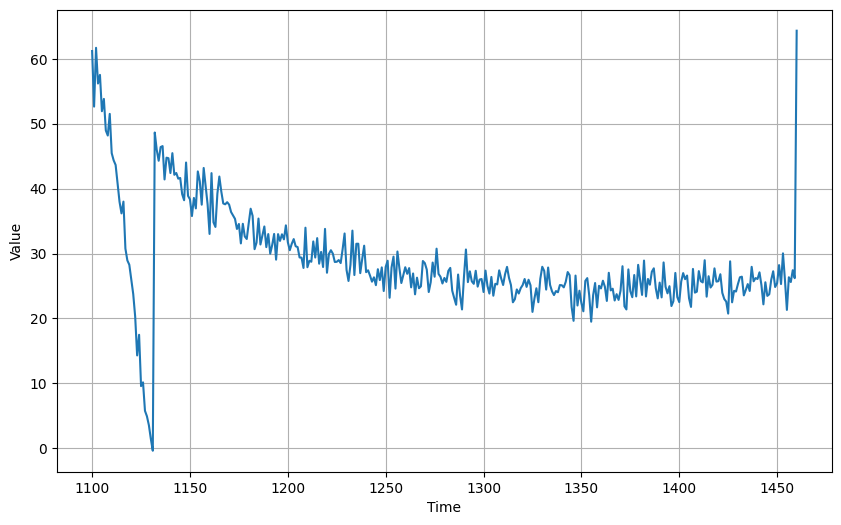

In [5]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Диаграмма С 4 пиками между 50 и 65 и 3 впадинами между -12 и 0
# Диаграмма с 2 пиками, первый чуть выше 60, последний чуть выше, также должен иметь одну впадину около 0

# Наивный прогноз (Naive Forecast)

In [6]:
naive_forecast = series[split_time - 1:-1]

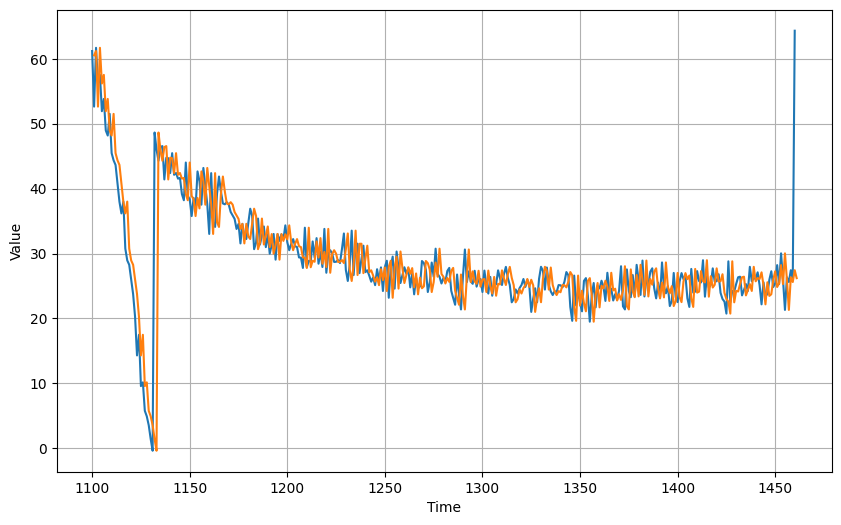

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid + 1, naive_forecast)

# Ожидаемый результат: диаграмма аналогична приведенной выше, но с наложением прогноза

Давайте увеличим масштаб начала периода проверки (валидационного периода):

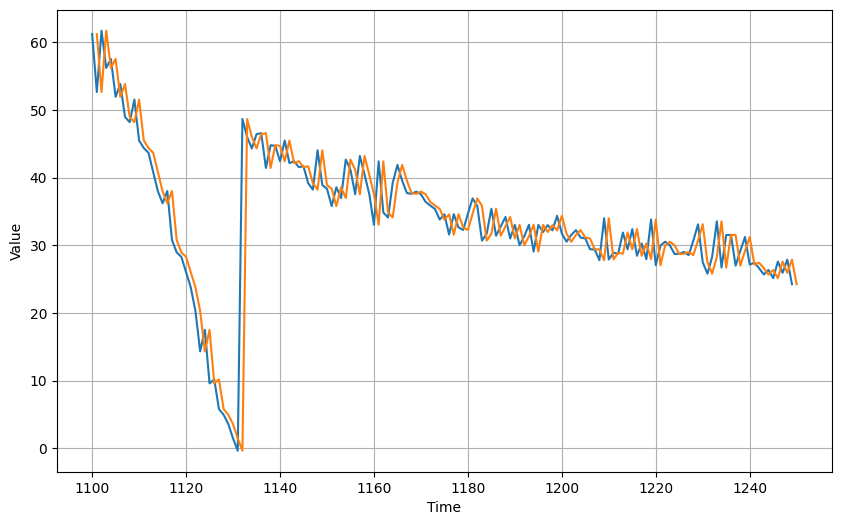

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

# EXPECTED - Диаграмма с осью X от 1100-1250 и осью Y с наблюдениями и прогнозами. 
# Прогнозы должны быть сделаны с временным шагом 1 единица после наблюдения (т.е. прогноз строится на один период вперед)

Теперь давайте вычислим среднеквадратичную ошибку и среднюю абсолютную ошибку между наблюдениями и прогнозами в период проверки (валидации):

In [21]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
# Expected Output
# 19.578304
# 2.6011968

19.578308
2.6011975


Это наша baseline, теперь давайте попробуем скользящую среднюю:

In [22]:
def moving_average_forecast(series, window_size):
    """Прогнозирует среднее значение последних нескольких значений.
        Если window_size=1, то это эквивалентно наивному прогнозу"""
    ### START CODE HERE  
    forecast = []
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
    
    ### END CODE HERE

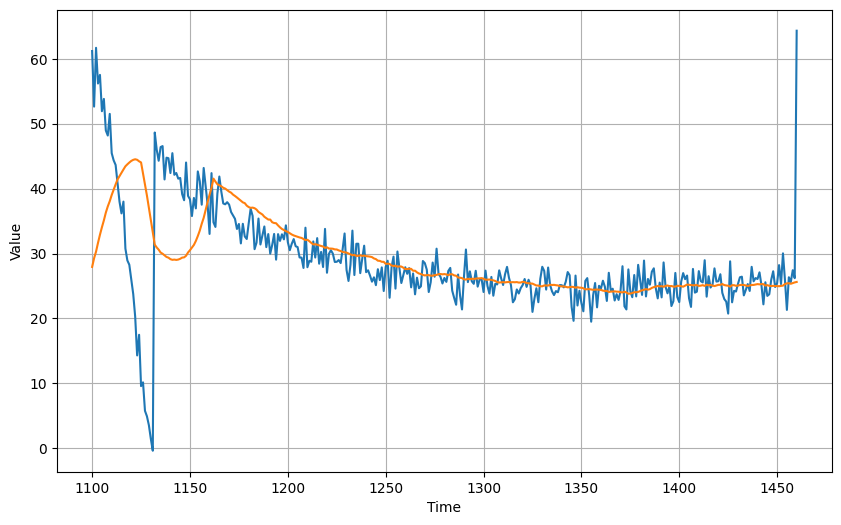

In [23]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
    
# EXPECTED OUTPUT
# Диаграмма с наблюдениями 1100->1450+ по X
# Построен временной ряд
# Построен график скользящего среднего

Теперь давайте вычислим среднеквадратичную ошибку и среднюю абсолютную ошибку между наблюдениями и прогнозами в период проверки (валидации):

In [31]:
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# EXPECTED OUTPUT
# 65.786224
# 4.3040023

65.786224
4.3040023


Скользящее среднее не предвидит тренд или сезонность, поэтому давайте попробуем удалить их, используя разность (дифференцирование). Поскольку период сезонности составляет 365 дней, мы вычтем значение в момент времени $t$ – 365 из значения в момент времени $t$.

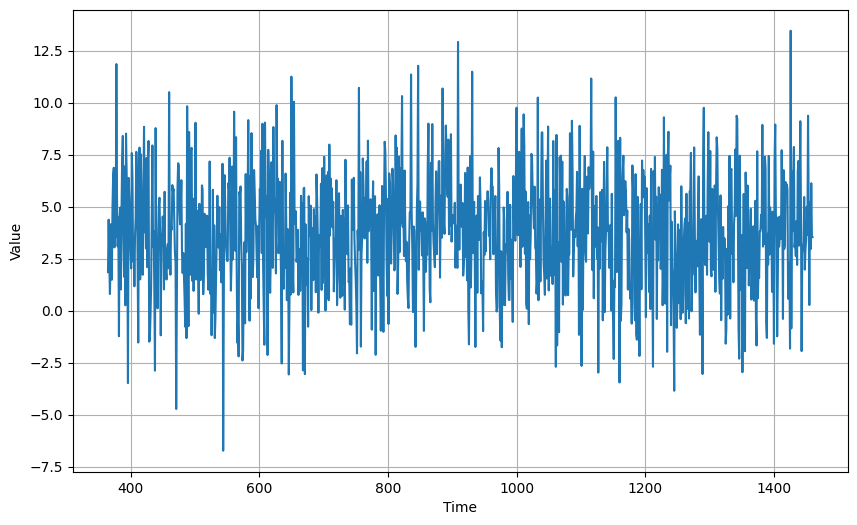

In [25]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()
    
# EXPECETED OUTPUT: Диаграмма ряда после дифференцирования

Отлично, тренд и сезонность, кажется, ушли, так что теперь мы можем использовать скользящее среднее:

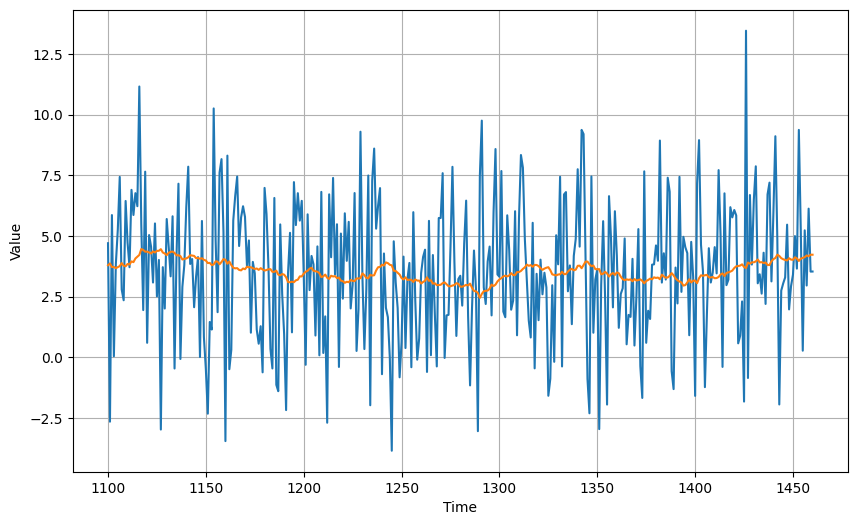

In [26]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()
            
# Expected output. Diff chart from 1100->1450 +
# График скользящей средней

Теперь давайте вернем тренд и сезонность, добавив прошлые значения от t – 365:

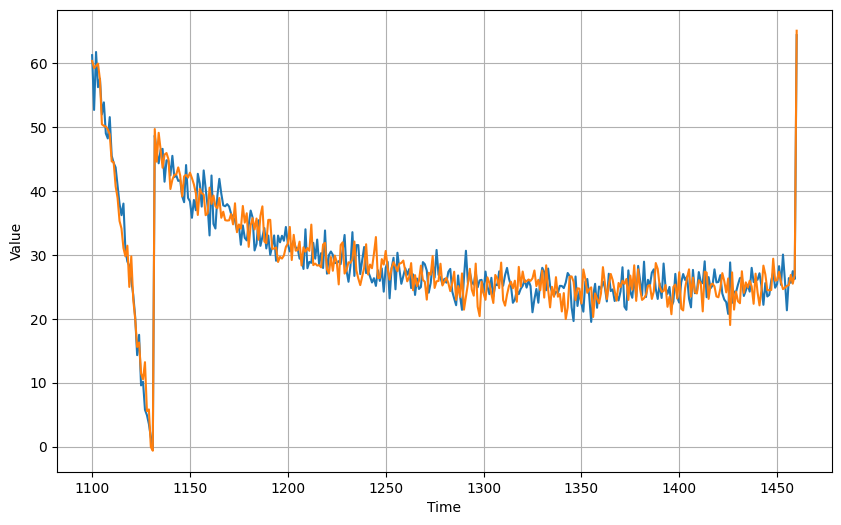

In [27]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()
# Expected output: Chart from 1100->1450+ on X. 
# Та же диаграмма, что и ранее для временных рядов, но наложенная модель выглядит близкой к ней по значению


In [32]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())
# EXPECTED OUTPUT
# 8.498155
# 2.327179

8.498155
2.3271792


Лучше наивного прогноза (naive forecast). Однако прогнозы выглядят слишком случайными, потому что мы просто добавляем прошлые значения, которые были зашумлены. Давайте используем скользящее усреднение по прошлым значениям, чтобы удалить часть шума:

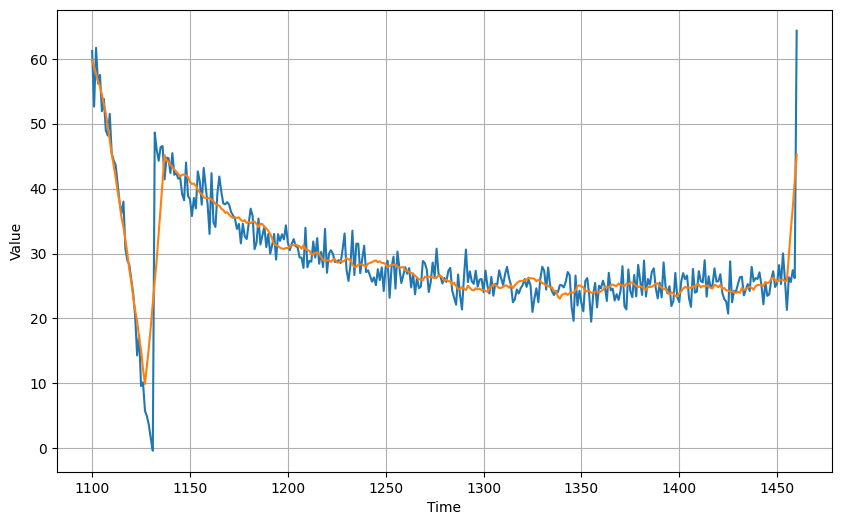

In [29]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()
            
# EXPECTED OUTPUT:
# Диаграмма похожа на приведенную выше, но наложенные модельные значения намного более гладкие.

In [33]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
# EXPECTED OUTPUT
# 12.527958
# 2.2034433

12.527958
2.2034435
